In [2]:
import cython
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
%load_ext Cython

In [64]:
%%cython

import numpy as np
cimport numpy as np
ctypedef np.double_t DTYPE_t
from libc.math cimport exp, sqrt, fabs, log
from scipy.special import iti0k0, k0
from scipy.integrate import quad

###############################to-be-deleted##########################
cpdef double sexp(double e, double yed):
    cdef double EPS = 1e-12, d, sum_
    cdef int m, MAXITER = 100
    for m in range(1, MAXITER):
        d = exp(-2*m*yed*e)
        sum_ += d
        if d < sum_*EPS:
            return sum_
    return sum_
######################################################################
cdef double bessi0(double x):
    cdef double ax, ans, y
    ax = fabs(x)
    if ax < 3.75:
        y = x/3.75
        y*=y
        ans=1.0+y*(3.5156229+y*(3.0899424+y*1.2067492+y*(0.2659732+y*(0.360768e-1+y*0.45813e-2))))
    else:
        y = 3.75/ax
        ans = y*(-0.1647633e-1+y*0.392377e-2)
        ans = 0.916281e-2+y*(-0.2057706e-1+y*(0.2635537e-1+ans))
        ans = 0.225319e-2+y*(-0.157565e-2+y*ans)
        ans = 0.39894228+y*(0.1328592e-1+y*ans)
        ans *= (exp(ax)/sqrt(ax))
    return ans
        
cdef double bessk0(double x):
    cdef double y, ans
    if x <= 2.:
        y = x*x/4.0
        ans=(-log(x/2.0)*bessi0(x))+(-0.57721566+y*(0.42278420+\
            y*(0.23069756+y*(0.3488590e-1+y*(0.262698e-2+\
            y*(0.10750e-3+y*0.74e-5))))))
    else:
        y=2./x
        ans=(exp(-x)/sqrt(x))*(1.25331414+y*(-0.7832358e-1+\
            y*(0.2189568e-1+y*(-0.1062446e-1+y*(0.587872e-2+\
            y*(-0.251540e-2+y*0.53208e-3))))))
    return ans

def F1(u, yd, ywd, yed):
    sum_ = 0
    su = np.sqrt(u)
    u_sexp = sexp(su, yed)
    ans = np.exp(-su*(2*yed-(yd+ywd))) + np.exp(-su*(yd+ywd)) + np.exp(-su*(2*yed-np.abs(yd-ywd))) +\
            np.exp(-su*np.abs(yd-ywd))
    ans *= (1+u_sexp)/su
    return ans

def iF1(x1, x2, u, yd, ywd, yed):
    return (x2-x1)*F1(u, yd, ywd, yed)

def F2E(buf, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd, yed):
    EPS = 1e-12
    blk_size = 10
    MAXITER = 100
    TINY = 1e-12
    mshape = ksid.shape
    assert ksiwd.shape == yd.shape == ywd.shape == mshape
    sum_ = np.zeros(mshape, dtype=np.double)
    for i in range(1, MAXITER):
        d = np.zeros(mshape, dtype=np.double)
        for k in range(i*blk_size, (i+1)*blk_size):
            d += F2E_k(k, buf, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd, yed)
        sum_ += d
        if np.linalg.norm(d) < EPS*(np.linalg.norm(sum_)+TINY):
            return sum_
            
def F2E_k(k, buf, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd, yed):
    if buf is None:
        yd_ywd = np.abs(yd-ywd)
        _yed_yd_ywd = 2*yed - yd_ywd
        yd_p_ywd = yd+ywd
        _yed_yd_p_ywd = 2*yed-yd_p_ywd
        a_ksid = np.pi*ksid/ksied
        a_ksiwd = np.pi*ksiwd/ksied
        buf = (a_ksid, a_ksiwd, yd_ywd, _yed_yd_ywd, yd_p_ywd, _yed_yd_p_ywd)
    else:
        a_ksid, a_ksiwd, yd_ywd, _yed_yd_ywd, yd_p_ywd, _yed_yd_p_ywd = buf
    ek = np.sqrt(u+np.square(k*np.pi/ksiede)+np.square(a))
    ek_sexp = sexp(ek, yed)
    ans = np.cos(k*a_ksid)*np.cos(k*a_ksiwd)/ek
    ans *= np.exp(-ek*_yed_yd_ywd)*(1+ek_sexp)+np.exp(-ek*yd_ywd)*ek_sexp +\
            (np.exp(-ek*_yed_yd_p_ywd)+np.exp(-ek*yd_p_ywd))*(1+ek_sexp)
    return ans

def iF2E(buf, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd, yed):
    EPS = 1e-12
    blk_size = 10
    MAXITER = 100
    mshape = ksid.shape
    sum_ = np.zeros(mshape, dtype=np.double)
    for i in range(MAXITER):
        d = np.zeros(mshape, dtype=np.double)
        for k in range(1+i*blk_size, 1+(i+1)*blk_size):
            d += iF2E_k(k, buf, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd, yed)
        sum_ += d
        if np.linalg.norm(d) < EPS*np.linalg.norm(sum_):
            return sum_
    return sum_
        
def iF2E_k(k, buf, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd, yed):
    yd_ywd = np.abs(yd-ywd)
    _yed_yd_ywd = 2*yed - yd_ywd
    yd_p_ywd = yd+ywd
    _yed_yd_p_ywd = 2*yed-yd_p_ywd
    a_ksid = np.pi*ksid/ksied
    a_ksiwd = np.pi*ksiwd/ksied
    ek = np.sqrt(u+np.square(k*np.pi/ksiede)+np.square(a))
    ek_sexp = sexp(ek, yed)
    pi=np.pi
    ans = ksied*np.cos(k*a_ksid)/(np.pi*k*ek)
    ans *= (np.sin(k*pi/ksied*(ksiwd+x2))-np.sin(k*pi/ksied*(ksiwd+x1)))
    ans *= np.exp(-ek*_yed_yd_ywd)*(1+ek_sexp)+np.exp(-ek*yd_ywd)*ek_sexp +\
           (np.exp(-ek*_yed_yd_p_ywd)+np.exp(-ek*yd_p_ywd))*(1+ek_sexp)
    return ans

def i1F2H(buf_yd0, buf_yd_nnz, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd):
    mshape = x1.shape
    assert x2.shape == mshape
    sum_ = i1F2Hk(buf_yd0, buf_yd_nnz, 0, 1, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd)
    sum_ += i1F2Hk(buf_yd0, buf_yd_nnz, 0, -1, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd)
    EPS = 1e-12
    blk_size = 3
    MAXITER = 100
    for i in range(MAXITER):
        d = np.zeros(mshape, dtype = np.double)
        for k in range(1+i*blk_size, 1+(i+1)*blk_size):
            d+= i1F2Hk(buf_yd0, buf_yd_nnz, k, 1, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd)
            d+= i1F2Hk(buf_yd0, buf_yd_nnz, -k, 1, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd)
            d+= i1F2Hk(buf_yd0, buf_yd_nnz, k, -1, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd)
            d+= i1F2Hk(buf_yd0, buf_yd_nnz, -k, -1, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd)
        sum_ += d
        if np.linalg.norm(d) < EPS*np.linalg.norm(sum_):
            return sum_

def i1F2Hk(buf_yd0, buf_yd_nnz, k, b, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd):
    NDIGITS = 6
    mshape = x1.shape
    assert x2.shape == mshape
    m = np.zeros(mshape, dtype=np.double)
    inds_dyd0 = np.isclose(yd,ywd)
    inds_dyd_nnz = np.logical_not(inds_dyd0)
    su = np.sqrt(u+np.square(a))
    if np.any(inds_dyd0):
        if str(k)+str(b) not in buf_yd0.keys():
            t1 = ksiede*((ksiwd[inds_dyd0]+x1[inds_dyd0])/ksied+b*ksid[inds_dyd0]/ksied-2*k)
            t2 = ksiede*((ksiwd[inds_dyd0]+x2[inds_dyd0])/ksied+b*ksid[inds_dyd0]/ksied-2*k)
            mask1 = np.ones_like(t1) - 2*(t1>0)
            mask2 = np.ones_like(t1) - 2*(t2<0)
            t1 = np.round(np.abs(t1), decimals=NDIGITS).flatten()
            t2 = np.round(np.abs(t2), decimals=NDIGITS).flatten()
            nt = len(t1)
            t = np.append(t1,t2)
            ut, inv_t = np.unique(t, return_inverse=True)
            buf_yd0[str(k)+str(b)] = (ut, inv_t, nt, mask1, mask2)
        else:
            ut, inv_t, nt, mask1, mask2 = buf_yd0[str(k)+str(b)]
        uv = ksied/ksiede/su*iti0k0(ut*su)[1]
        v = uv[inv_t]
        v1 = v[:nt]
        v2 = v[nt:]
        m[inds_dyd0] = v1*mask1+v2*mask2
    if np.any(inds_dyd_nnz):
        if str(k)+str(b) not in buf_yd_nnz.keys():
            t1 = ksiede*((ksiwd[inds_dyd_nnz]+x1[inds_dyd_nnz])/ksied+b*ksid[inds_dyd_nnz]/ksied-2*k)
            t2 = ksiede*((ksiwd[inds_dyd_nnz]+x2[inds_dyd_nnz])/ksied+b*ksid[inds_dyd_nnz]/ksied-2*k)
            dyd = np.round(np.abs(yd-ywd)[inds_dyd_nnz], decimals=NDIGITS).flatten()
            t1 = np.round(t1, decimals=NDIGITS).flatten()
            t2 = np.round(t2, decimals=NDIGITS).flatten()
            t = np.vstack([t1,t2]).T
            t = np.sort(t, axis=1)
            #print(t.shape)
            #print(dyd[np.newaxis].T.shape)
            t = np.hstack([t,dyd[np.newaxis].T])
            ut, inv_t = np.unique(t, axis=0, return_inverse=True)
            buf_yd_nnz[str(k)+str(b)] = (ut, inv_t)
        else:
            (ut, inv_t) = buf_yd_nnz[str(k)+str(b)]
        g = lambda x: ksied/ksiede*(quad(m_bessk0, x[0], x[1], args=(x[2], su))[0])
        uv = np.apply_along_axis(g, 1, ut).flatten()
        m[inds_dyd_nnz] = uv[inv_t]
    return m

def m_bessk0(x, dyd, su):
    return k0(su*np.sqrt(np.square(x)+np.square(dyd)))

def i2F2H(x1,x2,u,a,yd,ywd):
    su = np.sqrt(u+a*a)
    return -0.5*np.exp(-su*np.abs(yd-ywd))/su*(x2-x1)

def matr_pd_frac_nnnn(u, x1, x2, xd, xwd, xed, yd, ywd, yed):
    pi = np.pi
    buf_if2e = None
    buf_yd0, buf_yd_nnz = {}, {}
    ans = pi/xed*(0*0.5*iF1(x1, x2, u, yd, ywd, yed)+\
                  1*iF2E(buf_if2e, x1, x2, u, xd, xwd, xed, xed, 0, yd, ywd, yed)+\
                  0*0.5*xed/pi*i1F2H(buf_yd0, buf_yd_nnz, x1, x2, u, xd, xwd, xed, xed, 0, yd, ywd)+\
                  0*i2F2H(x1,x2,u,0,yd,ywd))
    return ans
    

In [137]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import iti0k0, k0
from scipy.integrate import quad
from scipy.integrate import fixed_quad

def sexp(e_, yed):
    TINY = 1e-20
    EPS = 1e-9
    MAXITER = 10000
    BLK_SIZE = 100
    if isinstance(e_, np.ndarray):
        e = e_.flatten().reshape(-1,1)
        sum_ = np.zeros_like(e_.flatten())
    else:
        e = e_
        sum_ = 0
    for i in range(MAXITER):
        m = np.arange(1+i*BLK_SIZE, 1+(i+1)*BLK_SIZE)
        d = np.sum(np.exp(-2*m*yed*e), axis=-1)
        sum_ += d
        if np.all(d < sum_*EPS) or np.all(sum_<TINY):
            return sum_
    return sum_

def F1(u, yd, ywd, yed):
    sum_ = 0
    su = np.sqrt(u)
    u_sexp = sexp(su, yed)
    ans = np.exp(-su*(2*yed-(yd+ywd))) + np.exp(-su*(yd+ywd)) + np.exp(-su*(2*yed-np.abs(yd-ywd))) +\
            np.exp(-su*np.abs(yd-ywd))
    ans *= (1+u_sexp)/su
    return ans

def iF1(x1, x2, u, yd, ywd, yed):
    return (x2-x1)*F1(u, yd, ywd, yed)

def iF2E(x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd, yed):
    EPS = 1e-12
    TINY = 1e-20
    blk_size = 10
    MAXITER = 1000
    mshape = ksid.shape
    sum_ = np.zeros(mshape, dtype=np.double)
    buf = []
    for i in range(MAXITER):
        d = np.zeros(mshape, dtype=np.double)
        k = np.arange(1+i*blk_size, 1+(i+1)*blk_size)
        d = np.sum(iF2Ek(k, buf, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd, yed), axis=0)
        sum_ += d
        ns = np.linalg.norm(sum_) 
        if np.linalg.norm(d) < EPS*ns or ns < TINY :
            return sum_
    return sum_
        
def iF2Ek(k_, buf, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd, yed):
    pi = np.pi
    if len(buf)==0:
        argx1 = pi*ksid/ksied
        argx2 = 0.5*pi/ksied*(x2-x1)
        argx3 = 0.5*pi/ksied*(2*ksiwd+x1+x2)
        argy1 = 2*yed-(yd+ywd)
        argy2 = yd+ywd
        argy3 = 2*yed - np.abs(yd-ywd)
        argy4 = np.abs(yd-ywd)
        buf = argx1, argx2, argx3, argy1, argy2, argy3, argy4
    elif len(buf) == 7:
        argx1, argx2, argx3, argy1, argy2, argy3, argy4 = buf
    else:
        raise RuntimeError("There is a problem with buffer in iF2Ek")
    ek_ = np.sqrt(u+np.square(k_*np.pi/ksiede)+np.square(a))
    _sexp_ = sexp(ek_, yed)
    if isinstance(k_, np.ndarray):
        _sexp_ = _sexp_.reshape(-1,1,1)
        k = k_.reshape(-1,1,1)
        ek = ek_.reshape(-1,1,1)
    else:
        k = k_
        ek = ek_
    ans = 2.*ksied/(pi*k*ek)*np.cos(k*argx1)*np.sin(k*argx2)*np.cos(k*argx3)
    ans *= (1+_sexp_)*(np.exp(-ek*argy1)+np.exp(-ek*argy2)+np.exp(-ek*argy3))+_sexp_*np.exp(-ek*argy4)
    return ans

def i1F2H(buf_yd0, buf_yd_nnz, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd):
    mshape = x1.shape
    assert x2.shape == mshape
    sum_ = i1F2Hk(buf_yd0, buf_yd_nnz, 0, 1, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd)
    sum_ += i1F2Hk(buf_yd0, buf_yd_nnz, 0, -1, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd)
    EPS = 1e-12
    blk_size = 3
    MAXITER = 100
    for i in range(MAXITER):
        d = np.zeros(mshape, dtype = np.double)
        for k in range(1+i*blk_size, 1+(i+1)*blk_size):
            d+= i1F2Hk(buf_yd0, buf_yd_nnz, k, 1, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd)
            d+= i1F2Hk(buf_yd0, buf_yd_nnz, -k, 1, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd)
            d+= i1F2Hk(buf_yd0, buf_yd_nnz, k, -1, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd)
            d+= i1F2Hk(buf_yd0, buf_yd_nnz, -k, -1, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd)
        sum_ += d
        if np.linalg.norm(d) < EPS*np.linalg.norm(sum_):
            return sum_

def i1F2Hk(buf_yd0, buf_yd_nnz, k, b, x1, x2, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd):
    NDIGITS = 6
    mshape = x1.shape
    assert x2.shape == mshape
    m = np.zeros(mshape, dtype=np.double)
    inds_dyd0 = np.isclose(yd,ywd)
    inds_dyd_nnz = np.logical_not(inds_dyd0)
    su = np.sqrt(u+np.square(a))
    if np.any(inds_dyd0):
        if str(k)+str(b) not in buf_yd0.keys():
            t1 = ksiede*((ksiwd[inds_dyd0]+x1[inds_dyd0])/ksied+b*ksid[inds_dyd0]/ksied-2*k)
            t2 = ksiede*((ksiwd[inds_dyd0]+x2[inds_dyd0])/ksied+b*ksid[inds_dyd0]/ksied-2*k)
            mask1 = np.ones_like(t1) - 2*(t1>0)
            mask2 = np.ones_like(t1) - 2*(t2<0)
            t1 = np.round(np.abs(t1), decimals=NDIGITS).flatten()
            t2 = np.round(np.abs(t2), decimals=NDIGITS).flatten()
            nt = len(t1)
            t = np.append(t1,t2)
            ut, inv_t = np.unique(t, return_inverse=True)
            buf_yd0[str(k)+str(b)] = (ut, inv_t, nt, mask1, mask2)
        else:
            ut, inv_t, nt, mask1, mask2 = buf_yd0[str(k)+str(b)]
        uv = ksied/ksiede/su*iti0k0(ut*su)[1]
        v = uv[inv_t]
        v1 = v[:nt]
        v2 = v[nt:]
        m[inds_dyd0] = v1*mask1+v2*mask2
    if np.any(inds_dyd_nnz):
        if str(k)+str(b) not in buf_yd_nnz.keys():
            t1 = ksiede*((ksiwd[inds_dyd_nnz]+x1[inds_dyd_nnz])/ksied+b*ksid[inds_dyd_nnz]/ksied-2*k)
            t2 = ksiede*((ksiwd[inds_dyd_nnz]+x2[inds_dyd_nnz])/ksied+b*ksid[inds_dyd_nnz]/ksied-2*k)
            dyd = np.round(np.abs(yd-ywd)[inds_dyd_nnz], decimals=NDIGITS).flatten()
            t1 = np.round(t1, decimals=NDIGITS).flatten()
            t2 = np.round(t2, decimals=NDIGITS).flatten()
            t = np.vstack([t1,t2]).T
            t = np.sort(t, axis=1)
            t = np.hstack([t,dyd[np.newaxis].T])
            ut, inv_t = np.unique(t, axis=0, return_inverse=True)
            buf_yd_nnz[str(k)+str(b)] = (ut, inv_t)
        else:
            (ut, inv_t) = buf_yd_nnz[str(k)+str(b)]
        g = lambda x: ksied/ksiede*(fixed_quad(m_bessk0, x[0], x[1], args=(x[2], su))[0])
        uv = np.apply_along_axis(g, 1, ut).flatten()
        m[inds_dyd_nnz] = uv[inv_t]
    return m

def m_bessk0(x, dyd, su):
    return k0(su*np.sqrt(np.square(x)+np.square(dyd)))

def i2F2H(x1,x2,u,a,yd,ywd):
    su = np.sqrt(u+a*a)
    return -0.5*np.exp(-su*np.abs(yd-ywd))/su*(x2-x1)

def matr_pd_frac_nnnn(u, x1, x2, xd, xwd, xed, yd, ywd, yed):
    pi = np.pi
    buf_if2e = None
    buf_yd0, buf_yd_nnz = {}, {}
    ans = pi/xed*(0.5*iF1(x1, x2, u, yd, ywd, yed)+\
                  iF2E(buf_if2e, x1, x2, u, xd, xwd, xed, xed, 0, yd, ywd, yed)+\
                  0.5*xed/pi*i1F2H(buf_yd0, buf_yd_nnz, x1, x2, u, xd, xwd, xed, xed, 0, yd, ywd)+\
                  i2F2H(x1,x2,u,0,yd,ywd))
    return ans

# Test for single frac

In [70]:
N = 20
nwells = 1
xwds = [xed/2]
ywds = [yed/2]
xed = 10
xwd_ = xed/2
yed = 10
ywd_ = yed/2
xd = np.tile(np.linspace(xwd_-1+0.5/N, xwd_+1-0.5/N, 2*N).reshape(-1,1), (1,2*N))
xwd = xwd_*np.ones_like(xd)
x1 = np.tile(np.arange(-N,N)/N, (2*N,1))
x2 = x1 + 1/N
yd = ywd_*np.ones_like(xd)
ywd = ywd_*np.ones_like(xd)

from new_struct.lapl_well import LaplWell
from new_struct.integrator import integrate_sources_for_green_matrix
outer_bound = "nnnn"
top_bound = "imp"
bottom_bound = "imp"
wtype = "frac"
attrs = {"Fcd": 10}
lwell = LaplWell(outer_bound, top_bound, bottom_bound,
        wtype, N, nwells, xwds=xwds, ywds=ywds, x_lengths = 1,
        xed = xed, yed = yed, zwds = None, hd = 0, attrs = attrs)
xis, xjs, xj1s, yws, yds, zws, zds = lwell.matrixizer.raw

from new_struct.integrators.frac_nnnn import *
lwell.matrixizer.make_matr_for_fb_1_2_nnnn(lwell.sources_)
arg_x_0, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4 = lwell.matrixizer.m_cache["fb_1_2_nnnn"]

In [76]:
u = 0.1
buf = []
m1 = np.pi/xed*iF2E(x1, x2, u, xd, xwd, xed, xed, 0, yd, ywd, yed)
m2 = ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
np.allclose(m1,m2)

False

In [77]:
%timeit -n10 -r10 np.pi/xed*iF2E(x1, x2, u, xd, xwd, xed, xed, 0, yd, ywd, yed)
%timeit -n10 -r10 ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)

1.03 ms ± 41.1 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
4.62 ms ± 16.9 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [79]:
m1 = 0.5*np.pi/xed*iF1(x1, x2, u, yd, ywd, yed)
m2 = ifb1(u, arg_x_0, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
print(np.allclose(m1,m2))
%timeit -n10 -r10 0.5*np.pi/xed*iF1(x1, x2, u, yd, ywd, yed)
%timeit -n10 -r10 ifb1(u, arg_x_0, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)

True
160 µs ± 13.7 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
123 µs ± 6.06 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [84]:
buf_yd0 = {}
buf_yd_nnz = {}
m1 = 0.5*i1F2H(buf_yd0, buf_yd_nnz, x1, x2, u, xd, xwd, xed, xed, 0, yd, ywd)
m2 = ifb3_1(u, lwell.matrixizer, lwell.sources_)
print(np.allclose(m1,m2))
%timeit -n10 -r10 0.5*i1F2H(buf_yd0, buf_yd_nnz, x1, x2, u, xd, xwd, xed, xed, 0, yd, ywd)
%timeit -n10 -r10 ifb3_1(u, lwell.matrixizer, lwell.sources_)

True
3.08 ms ± 18.8 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
1.05 ms ± 16.8 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [89]:
m1 = pi/xed*i2F2H(x1,x2,u,0,yd,ywd)
m2 = ifb3_2(u, arg_x_0, arg_y_4, xed)
print(np.allclose(m1,m2))
%timeit -n10 -r10 pi/xed*i2F2H(x1,x2,u,0,yd,ywd)
%timeit -n10 -r10 ifb3_2(u, arg_x_0, arg_y_4, xed)

True
26.4 µs ± 7.31 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
14.6 µs ± 4.21 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


### Only iF2E and fb_2 do not coincide. The difference is because in iF2E integration over xwd' while in fb_2 over (xwd-x')

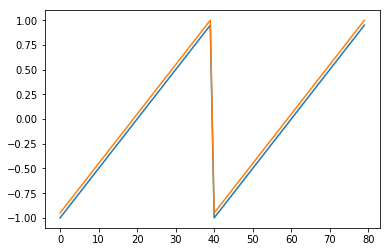

In [100]:
N = 20
nwells = 2
xed = 10
xwd__ = [xed/2, xed/2]
yed = 10
ywd__ = [yed/2-1, yed/2+1]
xd = np.tile(np.linspace(xwd_-1+0.5/N, xwd_+1-0.5/N, 2*N).reshape(-1,1), (nwells,2*N))
xwd = None
for xwd_ in xwd__:
    if xwd is None:
        xwd = xwd_*np.ones((2*N*nwells, 2*N))
    else:
        xwd = np.hstack([xwd, xwd_*np.ones((2*N*nwells, 2*N))])
ywd = None
for ywd_ in ywd__:
    if ywd is None:
        ywd = ywd_*np.ones((2*N*nwells, 2*N))
    else:
        ywd = np.hstack([ywd, ywd_*np.ones((2*N*nwells, 2*N))])
x1 = np.tile(np.arange(-N,N)/N, (2*N,nwells))
x2 = x1 + 1/N
plt.plot(x1[0])
plt.plot(x2[0])

# Test for multifrac

In [111]:
N = 20
nwells = 2
xed = 10
yed = 10
xwds = [xed/2, xed/2]
ywds = [yed/2-1, yed/2+1]
#init for new well
xd = None
for xwd_ in xwds:
    if xd is None:
        xd = np.tile(np.linspace(xwd_-1+0.5/N, xwd_+1-0.5/N, 2*N).reshape(-1,1), (1,2*N*nwells))
    else:
        xd = np.vstack([xd, np.tile(np.linspace(xwd_-1+0.5/N, xwd_+1-0.5/N, 2*N).reshape(-1,1), (1,2*N*nwells))])
xwd = None
for xwd_ in xwds:
    if xwd is None:
        xwd = xwd_*np.ones((2*N*nwells, 2*N))
    else:
        xwd = np.hstack([xwd, xwd_*np.ones((2*N*nwells, 2*N))])
ywd = None
for ywd_ in ywds:
    if ywd is None:
        ywd = ywd_*np.ones((2*N*nwells, 2*N))
    else:
        ywd = np.hstack([ywd, ywd_*np.ones((2*N*nwells, 2*N))])
yd = ywd.T
        
x1 = np.tile(np.arange(-N,N)/N, (2*N*nwells,nwells))
x2 = x1 + 1/N

#init for old well
from new_struct.lapl_well import LaplWell
from new_struct.integrator import integrate_sources_for_green_matrix
outer_bound = "nnnn"
top_bound = "imp"
bottom_bound = "imp"
wtype = "frac"
attrs = {"Fcd": 10}
lwell = LaplWell(outer_bound, top_bound, bottom_bound,
        wtype, N, nwells, xwds=xwds, ywds=ywds, x_lengths = 1,
        xed = xed, yed = yed, zwds = None, hd = 0, attrs = attrs)
xis, xjs, xj1s, yws, yds, zws, zds = lwell.matrixizer.raw
from new_struct.integrators.frac_nnnn import *
lwell.matrixizer.make_matr_for_fb_1_2_nnnn(lwell.sources_)
arg_x_0, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4 = lwell.matrixizer.m_cache["fb_1_2_nnnn"]

In [113]:
m1 = 0.5*np.pi/xed*iF1(x1, x2, u, yd, ywd, yed)
m2 = ifb1(u, arg_x_0, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
print(np.allclose(m1,m2))
%timeit -n10 -r10 0.5*np.pi/xed*iF1(x1, x2, u, yd, ywd, yed)
%timeit -n10 -r10 ifb1(u, arg_x_0, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)

True
489 µs ± 12.8 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
409 µs ± 8.37 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [114]:
u = 0.1
buf = []
m1 = np.pi/xed*iF2E(x1, x2, u, xd, xwd, xed, xed, 0, yd, ywd, yed)
m2 = ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
np.allclose(m1,m2)

False

In [138]:
buf_yd0 = {}
buf_yd_nnz = {}
m1 = 0.5*i1F2H(buf_yd0, buf_yd_nnz, x1, x2, u, xd, xwd, xed, xed, 0, yd, ywd)
m2 = ifb3_1(u, lwell.matrixizer, lwell.sources_)
print(np.allclose(m1,m2))
%timeit -n10 -r10 0.5*i1F2H(buf_yd0, buf_yd_nnz, x1, x2, u, xd, xwd, xed, xed, 0, yd, ywd)
%timeit -n10 -r10 ifb3_1(u, lwell.matrixizer, lwell.sources_)

True
69.3 ms ± 1.12 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
75.8 ms ± 74.4 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [119]:
m1 = pi/xed*i2F2H(x1,x2,u,0,yd,ywd)
m2 = ifb3_2(u, arg_x_0, arg_y_4, xed)
print(np.allclose(m1,m2))
%timeit -n10 -r10 pi/xed*i2F2H(x1,x2,u,0,yd,ywd)
%timeit -n10 -r10 ifb3_2(u, arg_x_0, arg_y_4, xed)

True
103 µs ± 9.78 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
73.6 µs ± 845 ns per loop (mean ± std. dev. of 10 runs, 10 loops each)


## The same result for multifrac